In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [2]:
training_data_file = open("./pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [3]:
import tensorflow as tf
import numpy as np
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# common params
IMAGE_SIZE = 224
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

# training params
LEARNING_RATE = 1e-4
EPOCHS = 300

# utils

In [5]:
def meshgrid(x, y, row_major=True):
    xx = tf.reshape(tf.tile(tf.range(x), [y]), [-1, 1])
    yy = tf.reshape(tf.tile(tf.reshape(tf.range(y), [-1, 1]), [1, x]), [-1, 1])
    return tf.concat([xx, yy], 1) if row_major else tf.concat([yy, xx], 1)


def change_box_order(boxes, order):
    assert order in ['xyxy2xywh', 'xywh2xyxy']
    a = boxes[:, :2]
    b = boxes[:, 2:]
    if order == 'xyxy2xywh':
        return tf.concat([(a + b) / 2, b - a], 1)
    return tf.concat([a - b / 2, a + b / 2], 1)


def box_iou(box1, box2, order='xyxy'):
    if order == 'xywh':
        box1, box2 = [change_box_order(i, 'xywh2xyxy') for i in [box1, box2]]

    # A: #box1, B: #box2
    lt = tf.maximum(box1[:, None, :2], box2[:, :2])  # [A, B, 2], coordinates left-top
    rb = tf.minimum(box1[:, None, 2:], box2[:, 2:])  # [A, B, 2], coordinates right-bottom

    wh = tf.clip_by_value(rb-lt,  # [A, B, 2], only clip the minimum
                          clip_value_min=0, clip_value_max=tf.float32.max)
    inter = wh[:, :, 0] * wh[:, :, 1]  # [A, B]
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])  # [A,]
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])  # [B,]
    iou = inter / (area1[:, None] + area2 - inter)
    return iou

# Encode : 
    ## Generate anchors
    ## Prepare corresponding ground truths
   
# Decode : 
    ## Decode the prediction from the model
    ## Get top-k boxes and then apply non-maximum suppression (NMS)

In [6]:
import math

def _make_list_input_size(input_size):
    input_size = [input_size] * 2 if isinstance(input_size, int) else input_size
    return tf.cast(input_size, tf.float32)

class BoxEncoder:
    def __init__(self):
        self.anchor_areas = [16 * 16., 32 * 32., 64 * 64., 128 * 128.]  
        self.aspect_ratios = [1 / 2., 1 / 1., 2 / 1.]
        self.scale_ratios = [1., pow(2, 1 / 3.), pow(2, 2 / 3.)]
        self.anchor_wh = self._get_anchor_wh()

    def _get_anchor_wh(self):
        """Compute anchor width and height for each feature map.
        Returns:
            anchor_wh: (tensor) anchor wh, sized [#fm, #anchors_per_cell, 2].
        """
        anchor_wh = []
        for s in self.anchor_areas:
            for ar in self.aspect_ratios:  # w/h = ar
                h = math.sqrt(s / ar)
                w = ar * h
                for sr in self.scale_ratios:  # scale
                    anchor_h = h * sr
                    anchor_w = w * sr
                    anchor_wh.append([anchor_w, anchor_h])
        num_fms = len(self.anchor_areas)
        return tf.reshape(anchor_wh, [num_fms, -1, 2])  # shape [5, 9(3x3), 2]

    def _get_anchor_boxes(self, input_size):
        """Compute anchor boxes for each feature map.
        Args:
            input_size: (list) model input size of (w, h)
        Returns:
            boxes: (list) anchor boxes for each feature map. Each of size [#anchors, 4],
                          where #anchors = fmw * fmh * #anchors_per_cell
        """
        num_fms = len(self.anchor_areas)
        fm_sizes = [(tf.math.ceil(input_size[0] / pow(2., i + 2)), tf.math.ceil(input_size[1] / pow(2., i + 2)))
                    for i in range(num_fms)]  
        boxes = []
        for i in range(num_fms):
            fm_size = fm_sizes[i]
            grid_size = tf.cast(tf.compat.v1.div(input_size, fm_size), tf.float32)
            fm_w, fm_h = fm_size[0], fm_size[1]
            xy = tf.cast(meshgrid(fm_w, fm_h), tf.float32) + 0.5  # [fm_h*fm_w, 2]
            xy = tf.tile(tf.reshape((xy * grid_size), [fm_h, fm_w, 1, 2]), [1, 1, 9, 1])
            wh = tf.tile(tf.reshape(self.anchor_wh[i], [1, 1, 9, 2]), [fm_h, fm_w, 1, 1])
            box = tf.concat([xy, wh], 3)  # [x, y, w, h]
            box = tf.reshape(box, [-1, 4])
            
            new_x = tf.expand_dims(box[:, 0] - box[:, 2] / 2, 1)
            new_y = tf.expand_dims(box[:, 1] - box[:, 3] / 2, 1)
            new_w = tf.expand_dims(box[:, 2], 1)
            new_h = tf.expand_dims(box[:, 3], 1)
            
            box = tf.concat([new_x, new_y, new_w, new_h], 1)
            boxes.append(box)
        return tf.concat(boxes, 0)

    def encode(self, boxes, labels, input_size):
        """Encode target bounding boxes and class labels.
        We obey the Faster RCNN box coder:
            tx = (x - anchor_x) / anchor_w
            ty = (y - anchor_y) / anchor_h
            tw = log(w / anchor_w)
            th = log(h / anchor_h)
        Args:
            boxes: (tensor) bounding boxes of (x, y, w, h), sized [#obj, 4]. => (x,y,w,h)
            labels: (tensor) object class labels, sized [#obj, ].
            input_size: (int/tuple) model input size of (w, h), should be the same.
        Returns:
            loc_trues: (tensor) encoded bounding boxes, sized [#anchors, 4].
            cls_trues: (tensor) encoded class labels, sized [#anchors, ].
        """
        input_size = _make_list_input_size(input_size)
        boxes = tf.reshape(boxes, [-1, 4])
        anchor_boxes = self._get_anchor_boxes(input_size)

        ious = box_iou(anchor_boxes, boxes, order='xywh')
        
        max_ids = tf.argmax(ious, axis=1)
        max_ious = tf.reduce_max(ious, axis=1)
        boxes = tf.gather(boxes, max_ids)  # broadcast automatically, [#anchors, 4]

        loc_xy = (boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:]
        loc_wh = tf.math.log(boxes[:, 2:] / anchor_boxes[:, 2:])
        loc_trues = tf.concat([loc_xy, loc_wh], 1)
        cls_trues = tf.gather(labels, max_ids)  
        cls_trues = tf.where(max_ious < 0.4, tf.zeros_like(cls_trues), cls_trues)
        ignore = (max_ious > 0.4) & (max_ious < 0.5)  # ignore ious between (0.4, 0.5), and marked as -1
        cls_trues = tf.where(ignore, tf.ones_like(cls_trues) * -1, cls_trues)
        cls_trues = tf.cast(cls_trues, tf.float32)
        return loc_trues, cls_trues
    
    def decode(self, loc_preds, cls_preds,
               input_size=(IMAGE_SIZE, IMAGE_SIZE),
               cls_thred=0.5,
               max_output_size=1,
               nms_thred=0.5,
               return_score=False,
               tf_box_order=True):
        """Decode outputs back to bouding box locations and class labels.
        Args:
            loc_preds: (tensor) predicted locations, sized [#anchors, 4].
            cls_preds: (tensor) predicted class labels, sized [#anchors, #classes].
            input_size: (int/tuple) model input size of (w, h), should be the same.
            cls_thred: class score threshold
            max_output_size: max output nums after nms
            nms_thred: non-maximum suppression threshold
            return_score: (bool) indicate whether to return score value.
            tf_box_order: (bool) True: [ymin, xmin, ymax, xmax]
                                False: [xmin, ymin, xmax, ymax]
        Returns:
            boxes: (tensor) decode box locations, sized [#obj, 4].
                            order determined by param: tf_box_order
            labels: (tensor) class labels for each box, sized [#obj, ].
        """
        assert len(loc_preds.get_shape().as_list()) == 2, 'Ensure the location input shape to be [#anchors, 4]'
        assert len(cls_preds.get_shape().as_list()) == 2, 'Ensure the class input shape to be [#anchors, #classes]'

        input_size = _make_list_input_size(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size)

        loc_xy = loc_preds[:, :2]
        loc_wh = loc_preds[:, 2:]

        xy = loc_xy * anchor_boxes[:, 2:] + anchor_boxes[:, :2]
        wh = tf.exp(loc_wh) * anchor_boxes[:, 2:]
        boxes = tf.concat([xy - wh / 2, xy + wh / 2], 1)  # [#anchors, 4]

        labels = tf.argmax(cls_preds, 1)  # [#anchors, ]
        score = tf.reduce_max(tf.sigmoid(cls_preds), 1)

        topk_ids = tf.nn.top_k(score, k = 1000)[-1] #get ids of top-k scores

        #use tmp_boxes for non max supression, avoiding to change the value of original boxes
        tmp_boxes = tf.transpose(tf.gather(tf.transpose(boxes), [1, 0, 3, 2]))
    
        keep = tf.image.non_max_suppression(tf.gather(tmp_boxes, topk_ids),
                                                    tf.gather(score, topk_ids),
                                                    max_output_size=20,
                                                    iou_threshold=nms_thred)
        def _index(t, index):
            """Gather tensor successively
            E.g., _index(boxes, [idx_1, idx_2]) = tf.gather(tf.gather(boxes, idx_1), idx_2)
            """
            if not isinstance(index, (tuple, list)):
                index = list(index)
            for i in index:
                t = tf.gather(t, i)
            return t
        
        return _index(boxes, [topk_ids, keep]), _index(labels, [topk_ids, keep]), _index(score, [topk_ids, keep])


# Plot anchors

In [7]:
box_vis = BoxEncoder()._get_anchor_boxes((224,224))
box_vis

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


<tf.Tensor: id=412, shape=(37485, 4), dtype=float32, numpy=
array([[ -3.6568542,  -9.313708 ,  11.313708 ,  22.627417 ],
       [ -5.1271896, -12.254379 ,  14.254379 ,  28.508759 ],
       [ -6.9796963, -15.959393 ,  17.959393 ,  35.918785 ],
       ...,
       [117.49033  , 162.74516  , 181.01933  ,  90.50967  ],
       [ 93.964966 , 150.98248  , 228.07007  , 114.035034 ],
       [ 64.32486  , 136.16243  , 287.35028  , 143.67514  ]],
      dtype=float32)>

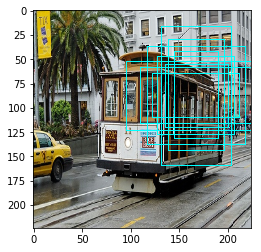

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
np_img = cv2.imread('./VOCdevkit_test/VOC2007/JPEGImages/001335.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

#xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
for obj1 in range(36000, 36009):
    cv2.rectangle(resized_img, (int(box_vis[obj1][0]), int(box_vis[obj1][1])), (int(box_vis[obj1][0])+int(box_vis[obj1][2]), int(box_vis[obj1][1])+int(box_vis[obj1][3])), (0, 255, 255), 1)
plt.imshow(resized_img)
plt.show()


# Dataset

In [9]:
import matplotlib.pyplot as plt
import random

class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline ready to be fed into a model.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        self.statistic = [0]*20
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')

            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))

            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
    
    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        image = tf.image.random_brightness(image,max_delta=0.3)
        image = tf.image.random_contrast(image,lower=0.8,upper=1.2)
        image = tf.image.random_hue(image,max_delta=0.1)
        image = tf.image.random_saturation(image,lower=0,upper=2)
 
        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_rate = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_rate = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.float32)
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
        
        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]
        
        #randomly flip image with bboxes
        if random.random() > 0.5:
            image = tf.image.flip_left_right(image)
            tmp_xmin = xmin            
            xmin = tf.cast(w, tf.float32) - xmax
            xmax = tf.cast(w, tf.float32) - tmp_xmin
        
        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate

        box_w = (xmax - xmin) * width_rate
        box_h = (ymax - ymin) * height_rate
        
        bboxes = tf.stack([xcenter, ycenter, box_w, box_h], axis = 1)
        labels = class_num+1
        return image, bboxes, labels, tf.cast(object_num, tf.int32)
    
    def _encode_boxes(self, image, bboxes, labels, object_num):
        loc_target, cls_target = BoxEncoder().encode(bboxes[:object_num], labels[:object_num], (IMAGE_SIZE, IMAGE_SIZE))
        return image, loc_target, cls_target, object_num
    
    def generate(self):
        
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(1000)
        dataset = dataset.map(self._data_preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(self._encode_boxes, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        
        return dataset


# Retinanet architecture

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.applications.vgg19 import preprocess_input

Using TensorFlow backend.


## Backbone: vgg-19-FPN

In [11]:
def leaky_relu(x):
    return tf.nn.leaky_relu(x, 0.1)

In [12]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=img_inputs)
print(vgg.summary())
for layers in vgg.layers:
    layers.activation = leaky_relu

c2 = vgg.get_layer('block2_pool').output
c3 = vgg.get_layer('block3_pool').output 
c4 = vgg.get_layer('block4_pool').output
c5 = vgg.get_layer('block5_pool').output

p5 = keras.layers.Conv2D(256, 1)(c5)
p4 = keras.layers.UpSampling2D()(p5)+keras.layers.Conv2D(256, 1)(c4)
p3 = keras.layers.UpSampling2D()(p4)+keras.layers.Conv2D(256, 1)(c3)
p2 = keras.layers.UpSampling2D()(p3)+keras.layers.Conv2D(256, 1)(c2)

p5 = keras.layers.Conv2D(256, 3, padding='same')(p5)
p4 = keras.layers.Conv2D(256, 3, padding='same')(p4)
p3 = keras.layers.Conv2D(256, 3, padding='same')(p3)
p2 = keras.layers.Conv2D(256, 3, padding='same')(p2)

FPN = keras.Model(inputs=img_inputs, outputs=(p2,p3,p4,p5), name="FPN")

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Classfication and localization are as described in 'Focal Loss for Dense Object Detection'

In [13]:
class _MakeHead(keras.Model):
    def __init__(self, out_planes):
        super(_MakeHead, self).__init__()
        self.conv1 = keras.layers.Conv2D(256, 3, 1, activation='relu', padding='same')
        self.conv2 = keras.layers.Conv2D(256, 3, 1, activation='relu', padding='same')
        self.conv3 = keras.layers.Conv2D(256, 3, 1, activation='relu', padding='same')
        self.conv4 = keras.layers.Conv2D(256, 3, 1, activation='relu', padding='same')

        self.conv_out = keras.layers.Conv2D(out_planes, 3, 1, activation=None, padding='same')
        
    def call(self, x):
        x = self.conv4(self.conv3(self.conv2(self.conv1(x))))
        return self.conv_out(x)

class RetinaNet(keras.Model):
    """ RetinaNet defined in Focal loss paper
     See: https://arxiv.org/pdf/1708.02002.pdf
    """
    num_anchors = 9
    num_classes = 20

    def __init__(self):
        super(RetinaNet, self).__init__()
        """
        Args:
            num_classes: # of classification classes
            num_anchors: # of anchors in each feature map
        """

        def head_block(out_planes, name=None):
            l = _MakeHead(out_planes)
            return l

        def fpn_block():
            l = FPN
            return l

        self.fpn = fpn_block()
        self.loc_head = head_block(self.num_anchors * 4)
        self.cls_head = head_block(self.num_anchors * self.num_classes)

    def call(self, x):
        batch_size = tf.shape(x)[0]
        feature_maps = self.fpn(x)
        loc_preds = []
        cls_preds = []
        for feature_map in feature_maps:
            loc_pred = self.loc_head(feature_map)
            cls_pred = self.cls_head(feature_map)
            # [N, 9*4, H, W] -> [N, H, W, 9*4] -> [N, H*W*9, 4]
            loc_pred = tf.reshape(tf.transpose(loc_pred, [0, 1, 2, 3]), [batch_size, -1, 4])
            cls_pred = tf.reshape(tf.transpose(cls_pred, [0, 1, 2, 3]), [batch_size, -1, self.num_classes])
            loc_preds.append(loc_pred)
            cls_preds.append(cls_pred)
        return tf.concat(loc_preds, axis=1), tf.concat(cls_preds, axis=1)

## Instead of smooth L1, we use balance L1 loss proposed in 'Libra R-CNN: Towards Balanced Learning for Object Detection' for bounding box regression

In [14]:
def focal_loss(x, y, num_classes):
    """Focal loss.
    Args:
        x: (tensor) sized [N, D]
        y: (tensor) sized [N,]
        num_classes: numbers of classes
    Return:
      (tensor) focal loss.
    """
    alpha = 0.25
    gamma = 2
 
    y = tf.cast(y, tf.int32)
    t = tf.one_hot(y, depth=num_classes + 1)  # [N, #total_cls]
    t = t[:, 1:]  # exclude background
    
    p = tf.sigmoid(x)
    pt = p * t + (1 - p) * (1 - t)  # pt = p if t > 0 else 1-p
    w = alpha * t + (1 - alpha) * (1 - t)  # w = alpha if t > 0 else 1-alpha
    
    w = w * tf.pow((1 - pt), gamma)
    return tf.compat.v1.losses.sigmoid_cross_entropy(t, x, w)

def balanced_l1_loss(pred,
                     target,
                     beta=1.0,
                     alpha=0.5,
                     gamma=1.5,
                     reduction='mean'):
    assert beta > 0

    diff = tf.abs(pred - target)
    b = np.e**(gamma / alpha) - 1
    loss = tf.where(
        diff < beta, alpha / b *
        (b * diff + 1) * tf.math.log(b * diff / beta + 1) - alpha * diff,
        gamma * diff + gamma / b - alpha * beta)

    return loss

def loss_fn(loc_preds, loc_trues, cls_preds, cls_trues, num_classes=20):
    """Compute loss between (loc_preds, loc_targets) and (cls_preds, cls_targets).
    Args:
        loc_preds: (tensor) predicted locations, sized [batch_size, #anchors, 4].
        loc_trues: (tensor) encoded target locations, sized [batch_size, #anchors, 4].
        cls_preds: (tensor) predicted class confidences, sized [batch_size, #anchors, #classes].
        cls_trues: (tensor) encoded target labels, sized [batch_size, #anchors].
    loss:
        (tensor) loss = BalanceL1Loss(loc_preds, loc_targets) + FocalLoss(cls_preds, cls_targets).
    """

    # 1. loc_loss: Balance L1 loss
    # ==================================================================
    mask_index = tf.where(cls_trues > 0)
    masked_loc_preds = tf.gather_nd(loc_preds, mask_index)  # [#valid_pos, 4]
    masked_loc_trues = tf.gather_nd(loc_trues, mask_index)  # [#valid_pos, 4]
    
    loc_loss = balanced_l1_loss(masked_loc_preds, masked_loc_trues)
    # ==================================================================

    # 2. cls_loss = FocalLoss(loc_preds, loc_trues)
    # ==================================================================
    mask_index = tf.where(cls_trues > -1)
    masked_cls_preds = tf.reshape(tf.gather_nd(cls_preds, mask_index), [-1, num_classes])  # [#valid_anchors, #cls]
    masked_cls_trues = tf.reshape(tf.gather_nd(cls_trues, mask_index), [-1])  # [#valid_anchors]

    cls_loss = focal_loss(masked_cls_preds, masked_cls_trues, num_classes)
    # ==================================================================

    return loc_loss, cls_loss


In [15]:
RetinaNet = RetinaNet()

# Training

In [16]:
dataset = DatasetGenerator().generate()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    LEARNING_RATE,
    decay_steps=80000,
    decay_rate=0.5,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(lr_schedule)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=RetinaNet)

manager = tf.train.CheckpointManager(ckpt, './ckpts/RetinaNet', max_to_keep=10,
                                     checkpoint_name='retinanet')

In [17]:
@tf.function
def train_step(image, loc_trues, cls_trues):
    with tf.GradientTape() as tape:
        loc_preds, cls_preds = RetinaNet(image)
        loc_loss, cls_loss = loss_fn(loc_preds, loc_trues, cls_preds, cls_trues, num_classes=20)
        total_loss = 5*loc_loss + cls_loss
        train_loss_metric(total_loss)

    grads = tape.gradient(total_loss, RetinaNet.trainable_weights)
    optimizer.apply_gradients(zip(grads, RetinaNet.trainable_weights))        

In [18]:
from datetime import datetime

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, loc_trues, cls_trues, objects_num) in enumerate(dataset):
        train_step(image, loc_trues, cls_trues)
    
    print("{}, Epoch {}: loss {:.5f}".format(datetime.now(), i+1, train_loss_metric.result()))
    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

# Predict Test data

In [19]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)
    image = tf.cast(image, tf.float32)
    
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255.0) * 2 - 1
    
    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)
ckpt = tf.train.Checkpoint(net=RetinaNet)
ckpt.restore('./ckpts/RetinaNet/retinanet-187')

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

def validation(img_path):
    np_img = cv2.imread(img_path)
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    resized_img = np_img
    np_img = np_img.astype(np.float32)
    np_img = np_img / 255.0 * 2 - 1
    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    
    loc_preds, cls_preds = RetinaNet(np_img)
    batch_loc, batch_cls, batch_score = BoxEncoder().decode(loc_preds[0,:,:], cls_preds[0,:,:])
    
    cls_threshold = 0.3  #filter out all the boxes with scores lower than the threshold
    
    #xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
    for obj1 in range(len(batch_loc)):
        if(batch_score[obj1] < cls_threshold):
            continue
        class_name = classes_name[batch_cls[obj1]]
        cv2.rectangle(resized_img, (int(batch_loc[obj1][0]), int(batch_loc[obj1][1])), (int(batch_loc[obj1][2]), int(batch_loc[obj1][3])), (0, 255, 255), 1)
    plt.imshow(resized_img)
    plt.show()

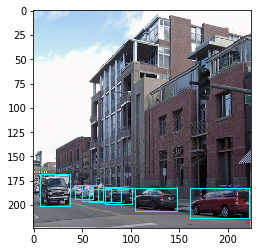

In [37]:
validation('./VOCdevkit_test/VOC2007/JPEGImages/000004.jpg')

# Make Prediction and Output to txt file

In [73]:
@tf.function
def prediction_step(img):
    return RetinaNet(img)

In [72]:
output_file = open('./test_prediction.txt', 'w')
cls_threshold = 0.1

for img_name, test_img, img_h, img_w in test_dataset:
    batch_nums = img_name.shape[0]
    for i in range(batch_nums):
        loc_preds, cls_preds = prediction_step(test_img[i:i+1])
        batch_loc, batch_cls, batch_score = BoxEncoder().decode(loc_preds[0,:,:], cls_preds[0,:,:])
        
        output_file.write(img_name.numpy()[i].decode('ascii'))
        for obj in range(len(batch_loc)):
            xmin = int(batch_loc[obj][0]*(int(img_w[i])/IMAGE_SIZE))
            xmin = max(xmin, 0)
            ymin = int(batch_loc[obj][1]*(int(img_h[i])/IMAGE_SIZE))
            ymin = max(ymin, 0)
            xmax = int(batch_loc[obj][2]*(int(img_w[i])/IMAGE_SIZE))
            xmax = min(xmax, img_w[i])
            ymax = int(batch_loc[obj][3]*(int(img_h[i])/IMAGE_SIZE))
            ymax = min(ymax, img_h[i])
            class_num = int(batch_cls[obj])
            score = float(batch_score[obj])
            if score < cls_threshold:
                continue
            output_file.write(" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, class_num, score))
        output_file.write("\n")
        
output_file.close()

In [73]:
import sys
sys.path.insert(0, './evaluate')
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

End Evalutation
